# Forestal Fire Cabezuela del Valle, Cáceres, Spain

## Fire information
**1. Location**

Extremadura, Spain


**2. Date interval**

   *Start: 27/08/2020*
   *Finished (declared extinguished): 05/09/2020*


**3. Hectares burnt**

    4009 ha


In [409]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url='https://est.zetaestaticos.com/badajoz/img/noticias/0/373/373709_1.jpg')

In the following video obtained from the Spanish Army you can see the fire from the seaplanes used to fight the fire.

In [444]:
%%html
<blockquote class="twitter-tweet"><p lang="es" dir="ltr"> <a href="https://twitter.com/hashtag/Corsarios?src=hash&amp;ref_src=twsrc%5Etfw">#Corsarios</a> del <a href="https://twitter.com/hashtag/43Grupo?src=hash&amp;ref_src=twsrc%5Etfw">#43Grupo</a> 🔥. Acabar con los incendios forestales <a href="https://twitter.com/hashtag/IIFF?src=hash&amp;ref_src=twsrc%5Etfw">#IIFF</a> es un trabajo de equipo. Nosotros siempre estaremos ahí para darlo todo 🇪🇸. <a href="https://twitter.com/hashtag/IFCabezuelaDelValle?src=hash&amp;ref_src=twsrc%5Etfw">#IFCabezuelaDelValle</a> <a href="https://twitter.com/gimmylxvii?ref_src=twsrc%5Etfw">@gimmylxvii</a> <a href="https://twitter.com/Defensagob?ref_src=twsrc%5Etfw">@Defensagob</a> <a href="https://twitter.com/mitecogob?ref_src=twsrc%5Etfw">@Mitecogob</a> <a href="https://t.co/z6zCtPtFIg">pic.twitter.com/z6zCtPtFIg</a></p>&mdash; Ejército del Aire (@EjercitoAire) <a href="https://twitter.com/EjercitoAire/status/1299605536749637637?ref_src=twsrc%5Etfw">August 29, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

--------------------

## Fire Analysis

#### Access to the SentinelHub API 

In [411]:
from sentinelhub import SHConfig
# In case you put the credentials into the configuration file you can leave this unchanged
CLIENT_ID = 'ea07da69-1ca0-4d05-9210-844a5bd8282f'
CLIENT_SECRET = 'C:4maj_u_f8_P:QB5da%OOD^U*!Xp0u0{^vzm]W['

In [412]:
config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")
print(config)

{
  "instance_id": "",
  "sh_client_id": "ea07da69-1ca0-4d05-9210-844a5bd8282f",
  "sh_client_secret": "C:4maj_u_f8_P:QB5da%OOD^U*!Xp0u0{^vzm]W[",
  "sh_base_url": "https://services.sentinel-hub.com",
  "geopedia_wms_url": "https://service.geopedia.world",
  "geopedia_rest_url": "https://www.geopedia.world/rest",
  "aws_access_key_id": "",
  "aws_secret_access_key": "",
  "aws_metadata_url": "https://roda.sentinel-hub.com",
  "aws_s3_l1c_bucket": "sentinel-s2-l1c",
  "aws_s3_l2a_bucket": "sentinel-s2-l2a",
  "opensearch_url": "http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2",
  "max_wfs_records_per_query": 100,
  "max_opensearch_records_per_query": 500,
  "max_download_attempts": 4,
  "download_sleep_time": 5,
  "download_timeout_seconds": 120,
  "number_of_download_processes": 1
}


In [413]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#### Imports

In [414]:
import os
import datetime
from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, DataCollection, bbox_to_dimensions, DownloadRequest


#For reading files
import rasterio
import osgeo.gdal
#For visualization
from rasterio import plot
from rasterio.plot import show
import matplotlib.pyplot as plt

#For analysis
import pandas as pd
import numpy as np
from scipy import stats

In [415]:
#Definition of the plot function
def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

------------------------

#### Definition of Bounding Box 

In [416]:
cabezuela_coords = [-5.807,40.098,-5.662,40.189]

In [417]:
resolution = 20
cabezuela_bbox = BBox(bbox=cabezuela_coords, crs=CRS.WGS84)
cabezuela_size = bbox_to_dimensions(cabezuela_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {cabezuela_size} pixels')

Image shape at 20 m resolution: (633, 486) pixels


### Fire analysis 

The analysis that is going to be carried on is regarding these index: Atmospheric penetration, NBR (and dNBR) and SWIR.



**1.Atmospheric penetration**

The importance of this band combination is because it involves no visible bands while penetrating atmospheric particles, smoke and haze reducing the atmospheric influence in the image. So, when the fire starts, the atmospheric penetration changes due to the fire ashes and smoke.

---

**2. NBR**

The *Normalized Brun Ratio (NBR)* can be used to highlight the burnt areas and identify the severity. It is calculated with the B8 and B12 bands.

The formula is ***NBR = (NIR - SWIR) / (NIR + SWIR)***

   **2.1. Differenced Normalized Burn Ratio (dNBR)**

   The difference normalized burn ratio is calculated with the Pre-fire NBR and the Post-fire    NBR as the next formula

   ***dNBR = Pre NBR - Post NBR***

---


**3.SWIR**

With the Soft Wave Infrared (SWIR) bands (12,8,4) is possible to know how much water is present in plants and soils.
The newly burned areas reflect strongly in SWIR bands. 


------------------

#### FIRE BOUNDARY

Script to delimit the boundary of the fire. Taken in the day of the highest fire activity

In [418]:
evalscript_fire ="""
//VERSION=3 (auto-converted from 1)
      /*
Authors of the script: Adzanil Rachmadhi Putra, Fatwa Ramdani
*/

function setup() {
  return {
    input: [{
      bands: [
          "B11",
          "B12"
      ]
    }],
    output: { bands: 1 }
  }
}


let viz = new HighlightCompressVisualizerSingle(-1.0, 1.0);

function evaluatePixel(samples) {
  let val = 8.5 * (samples.B12 - samples.B11) / (samples.B12 + samples.B11 + 0.25); return viz.process(val);
}
"""


request_fire = SentinelHubRequest(
    data_folder='Sentinel2_savedimages',
    evalscript=evalscript_fire,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2020-08-29','2020-08-31'),
            mosaicking_order = 'mostRecent'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=cabezuela_bbox,
    size=cabezuela_size,
    config=config
)

In [419]:
%%time
cabezuela_boundary = request_fire.get_data(save_data=True)
image_boundary = cabezuela_boundary[0]

CPU times: user 5.46 ms, sys: 2.47 ms, total: 7.93 ms
Wall time: 78.5 ms


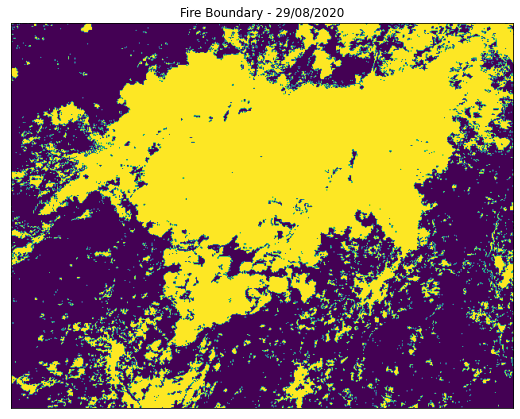

In [420]:
plot_image(image_boundary,factor=255/255, clip_range=(0,1))
plt.title('Fire Boundary - 29/08/2020')

print()

In [421]:
%%time
burnScar = request_burnScar.get_data(save_data=True)
image_pre = burnScar[0]

CPU times: user 37.1 ms, sys: 13.6 ms, total: 50.7 ms
Wall time: 208 ms


### Fire burn Scar
This is an script to hightlight burn scars

In [422]:
evalscript_burnScar = """
    //Property of Pierre Markuse
    //CC BY 4.0 International
    function a(a, b) {return a + b};
    function stretch(val, min, max) {return (val - min) / (max - min);}

    function satEnh(rgbArr) {
        var avg = rgbArr.reduce((a, b) => a + b, 0) / rgbArr.length;
        return rgbArr.map(a => avg * (1 - saturation) + a * saturation); }

    function highlightBurnscar(val, oLow, oHigh, deSat, darken) {
        if ((B12 + B11 > 0.05) && (val > 0)) {
            if (((B8A - B12) / (B8A + B12)) > oLow) {
                saturation = saturation - deSat;
                stretchMax = stretchMax + darken;
            } else {
                if (((B8A - B12) / (B8A + B12)) <= oHigh) {
                    noFire[0] = noFire[0] + 0.2 * val;
                    noFire[1] = noFire[1] + 0.05 * val;
                } else {
                    noFire[0] = noFire[0] + 0.15 * val;
                    noFire[1] = noFire[1] + 0.15 * val;
                }
            }
        }
    }

    function indexMap(ind, lVal, mVal, hVal, cont, dir, pal) {
      var col1=GREEN;var col2=YELLOW;var col3=RED;  
      if (pal == 1) {col1=CBL;col2=CBM;col3=CBH;} 
      if (pal == 2) {col1=OWNL;col2=OWNM;col3=OWNH;}         
        var lValCol = col1;
        var mValCol = col2;var hValCol = col3;
        if (dir == 1){
            lValCol = col3;hValCol = col1;
        }
        if (cont == 0) {
            if (ind <= lVal) return lValCol; if ((ind > lVal) && (ind < hVal)) return mValCol; if (ind >= hVal) return hValCol;
          } else {
            return colorBlend(ind, [lVal, mVal,hVal], [lValCol,mValCol,hValCol]);
        }
    }

    function blend(bArr1, bArr2, opa1, opa2) {
        return bArr1.map(function(num, index) {
            return (num / 100 * opa1 + bArr2[index] / 100 * opa2);
        });
    }

    function applyEnh(bArr) {
        highlightBurnscar(burnscarHighlight, burnscarThresholdLow, burnscarThresholdHigh, burnscarDesaturateBackdrop, burnscarDarkenBackdrop);
        return satEnh([stretch(bArr[0], stretchMin, stretchMax), stretch(bArr[1], stretchMin, stretchMax), stretch(bArr[2], stretchMin, stretchMax)]);
    }

    var BLACK = [0.0, 0.0, 0.0];
    var RED = [0.9, 0.1, 0.1];
    var YELLOW = [0.9, 0.9, 0.1];
    var GREEN = [0.0, 0.6, 0.0];
    var CBL  = [0/255, 80/255, 0/255];
    var CBM  = [120/255, 120/255, 230/255];
    var CBH  = [70/255, 195/255, 255/255];
    var OWNL = [0.0, 0.0, 0.0];
    var OWNM = [0.0, 0.0, 0.0];
    var OWNH = [0.0, 0.0, 0.0];

    // Visualization style of the different fire zones
    var Fire1OVL = [stretch((2.1 * B04 + 0.5 * B12), 0.01, 0.99) + 1.1, stretch((2.2 * B03 + 0.5 * B08), 0.01, 0.99), stretch(2.1 * B02, 0.01, 0.99)];
    var Fire2OVL = [stretch((2.1 * B04 + 0.5 * B12), 0.01, 0.99) + 1.1, stretch((2.2 * B03 + 0.5 * B08), 0.01, 0.99) + 0.25, stretch(2.1 * B02, 0.01, 0.99)];
    var Fire3OVL = [stretch((2.1 * B04 + 0.5 * B12), 0.01, 0.99) + 1.1, stretch((2.2 * B03 + 0.5 * B08), 0.01, 0.99) + 0.5, stretch(2.1 * B02, 0.01, 0.99)];

    // Band combinations (To get quicker processing you should comment out all those you are not using in the Settings further down)
    var NaturalColors = [2.9 * B04, 3.1 * B03, 3.0 * B02];
    // var EnhancedNaturalColors = [2.8 * B04 + 0.1 * B05, 2.8 * B03 + 0.15 * B08, 2.8 * B02];
    // var NaturalNIRSWIRMix = [2.1 * B04 + 0.5 * B12, 2.2 * B03 + 0.5 * B08, 3.0 * B02];
    // var NIRSWIRColors1 = [2.6 * B12, 1.9 * B08, 2.7 * B02];
    var NIRSWIRColors2 = [2.4 * B12, 1.7 * B8A, 2.2 * B05];
    // var NIRSWIRColors3 = [0.5 * (B12 + B11) / 4 / B07, 0.8 * B8A, 1 * B07];
    // var NIRSWIRColors4 = [2.0 * B12, 1.1 * B11, 1.6 * B08];
    // var FalseColor = [B08 * 2, B04 * 2, B03 * 2];
    // var NatFalseColor = [B12 * 2.6, B11 * 2, B04 * 2.7];
    // var Vegetation = [B11 * 2.4, B8A * 2, B04 * 2.9];
    // var PanBand = [B08, B08, B08];
    // var NBR8A12 = indexMap((B8A - B12) / (B8A + B12), -0.8, -0.4, 0.0, 1, 1, 1);
    // var NDVI = indexMap((B08 - B04) / (B08 + B04), -0.4, -0.2, 0.0, 1, 1, 1);

    // Settings

    // Fire (hot spot) visualization
    var fire1 = Fire1OVL;
    var fire2 = Fire2OVL;
    var fire3 = Fire3OVL;

    // Used band combinations and mixing
    var layer1 = NIRSWIRColors2;
    var layer2 = NaturalColors;
    var layer1Amount = 0;
    var layer2Amount = 100;

    // Influence contrast and saturation
    var stretchMin = 0.01;
    var stretchMax = 0.90;
    var saturation = 1.10;

    // Fire sensitivity (Default = 1.00), higher values increase fire (hot spot) detection and false positives
    var fireSensitivity = 1.00;

    // Burn scar visualization
    var burnscarHighlight = 0.00;
    var burnscarThresholdLow = -0.25;
    var burnscarThresholdHigh = -0.38;
    var burnscarDesaturateBackdrop = 0.25;
    var burnscarDarkenBackdrop = 0.25;

    // Manually influence RGB output
    var manualCorrection = [0.00, 0.00, 0.00];

    // Image generation and output
    noFire = blend(layer1, layer2, layer1Amount, layer2Amount);

    finalRGB = applyEnh(noFire).map(function(num, index) {
        return num + manualCorrection[index];});

    return (a(B12, B11) > (1.0 / fireSensitivity)) ?
        (a(B12, B11) > (2.0 / fireSensitivity)) ? fire3 :
        (a(B12, B11) > (1.5 / fireSensitivity)) ? fire2 : fire1 :
       finalRGB;
"""


request_burnScar = SentinelHubRequest(
    data_folder='Sentinel2_savedimages',
    evalscript=evalscript_burnScar,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2020-08-27','2020-08-29'),
            mosaicking_order = 'mostRecent'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=cabezuela_bbox,
    size=cabezuela_size,
    config=config
)

In [423]:
%%time
burnScar = request_burnScar.get_data(save_data=True)
image_pre = burnScar[0]

CPU times: user 44.3 ms, sys: 11 ms, total: 55.3 ms
Wall time: 3.21 s


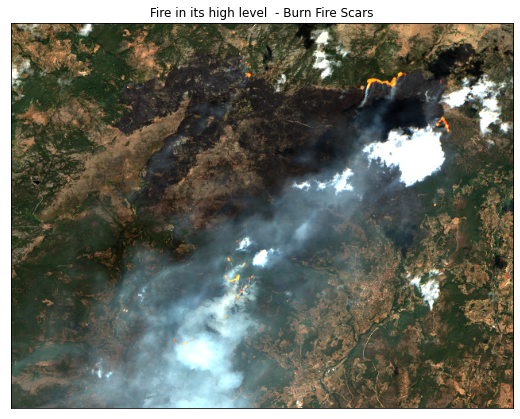

In [424]:
plot_image(image_pre,factor=1/255, clip_range=(0,1))
plt.title('Fire in its high level  - Burn Fire Scars')
print()

--------------

#### 1. Atmospheric penetration

In [425]:
#BEFORE FIRE

evalscript_atmosp = """
    //VERSION=3

    let minVal = 0.0;
    let maxVal = 0.4;

    let viz = new HighlightCompressVisualizer(minVal, maxVal);

    function setup() {
      return {
        input: ["B8A", "B11", "B12"],
        output: { bands: 3 }
      };
    }

    function evaluatePixel(samples) {
      let val = [samples.B12, samples.B11, samples.B8A];
      return viz.processList(val);
    }
"""

request_atmos_pre = SentinelHubRequest(
    data_folder='Sentinel2_savedimages',
    evalscript=evalscript_atmosp,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2020-08-23','2020-08-24'),
            mosaicking_order = 'mostRecent'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=cabezuela_bbox,
    size=cabezuela_size,
    config=config
)

In [426]:
%%time
cabezuela_pre = request_atmos_pre.get_data(save_data=True)
image_pre = cabezuela_pre[0]

CPU times: user 9.26 ms, sys: 2.73 ms, total: 12 ms
Wall time: 55.1 ms


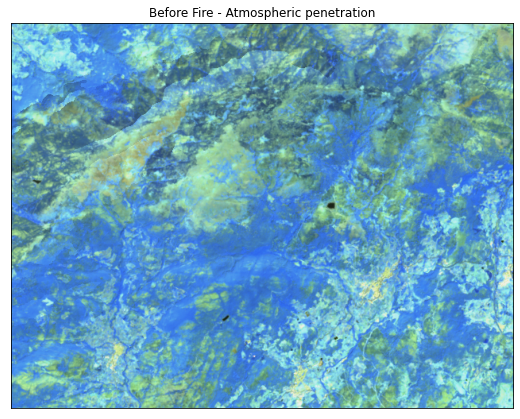

In [427]:
plot_image(image_pre,factor=1/255, clip_range=(0,1))
plt.title('Before Fire - Atmospheric penetration')
print()

In [428]:
#POST FIRE

evalscript_atmosp_post = """
    //VERSION=3

    let minVal = 0.0;
    let maxVal = 0.4;

    let viz = new HighlightCompressVisualizer(minVal, maxVal);

    function setup() {
      return {
        input: ["B8A", "B11", "B12"],
        output: { bands: 3 }
      };
    }

    function evaluatePixel(samples) {
      let val = [samples.B12, samples.B11, samples.B8A];
      return viz.processList(val);
    }
"""

request_atmos_post = SentinelHubRequest(
    data_folder='Sentinel2_savedimages',
    evalscript=evalscript_atmosp_post,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2020-09-03','2020-09-05'),
            mosaicking_order = 'mostRecent'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=cabezuela_bbox,
    size=cabezuela_size,
    config=config
)

In [429]:
%%time
cabezuela_post = request_atmos_post.get_data(save_data=True)
image_post = cabezuela_post[0]

CPU times: user 11.9 ms, sys: 3.5 ms, total: 15.4 ms
Wall time: 31.1 ms


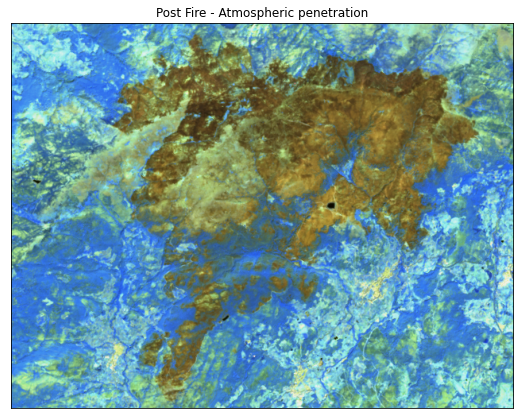

In [430]:
plot_image(image_post,factor=1/255, clip_range=(0,1))
plt.title('Post Fire - Atmospheric penetration')
print()

In [431]:
#Note: I was trying to put both images side by side but I was not able to do that by code


<table><tr>
<td> 
  <p align="center" style="padding: 2 px">
    <img alt="Pre fire" src="atmos_prefire.png" width="500">
    <br>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Post fire" src="atmos_postfire.png" width="515">
    <br>
  </p> 
</td>
</tr></table>

We can see in the picture located in the right part the burnt area of the Fire (coloured in range of browns)

-------------

#### 2. NBR

In [432]:
#BEFORE FIRE

evalscript_nbr_pre = """
    //VERSION=3

    let index = (B08 - B12) / (B08 + B12);
    return [index]
"""

request_nbr_pre = SentinelHubRequest(
    data_folder='Sentinel2_savedimages',
    evalscript=evalscript_nbr_pre,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2020-08-23','2020-08-24'),
            mosaicking_order = 'mostRecent'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=cabezuela_bbox,
    size=cabezuela_size,
    config=config
)

In [433]:
%%time
cabezuela_pre = request_nbr_pre.get_data(save_data=True)
image_pre = cabezuela_pre[0]

CPU times: user 6.58 ms, sys: 2.41 ms, total: 8.99 ms
Wall time: 28.9 ms


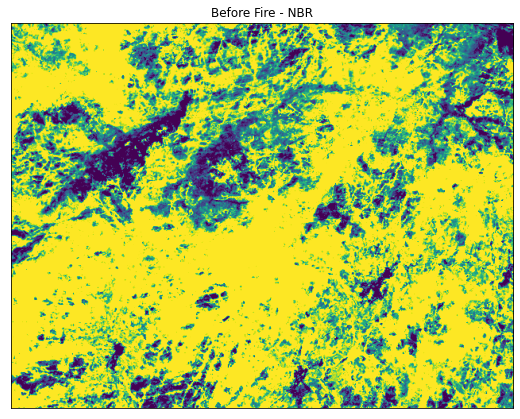

In [434]:
plot_image(image_pre,factor=3.5/255, clip_range=(0,1))
plt.title('Before Fire - NBR')
print()

In [435]:
#POST FIRE

evalscript_nbr_post = """
    //VERSION=3

    let index = (B08 - B12) / (B08 + B12);
    return [index]
"""


request_nbr_post = SentinelHubRequest(
    data_folder='Sentinel2_savedimages',
    evalscript=evalscript_nbr_post,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2020-09-03','2020-09-05'),
            mosaicking_order = 'mostRecent'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=cabezuela_bbox,
    size=cabezuela_size,
    config=config
)

In [436]:
%time
cabezuela_post = request_nbr_post.get_data(save_data=True)
image_post = cabezuela_post[0]

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


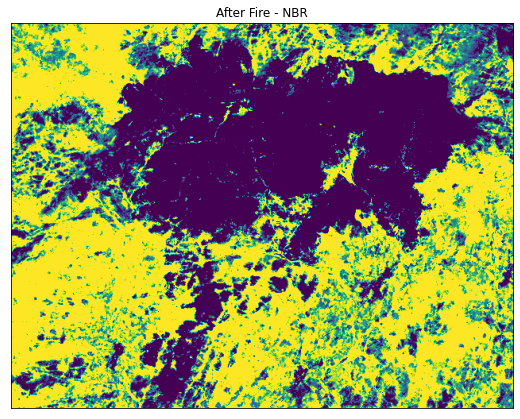

In [437]:
plot_image(image_post,factor=3.5/255, clip_range=(0,1))
plt.title('After Fire - NBR')
print()

-----------

<table><tr>
<td> 
  <p align="center" style="padding: 2 px">
    <img alt="Pre fire" src="NBR_pre.png" width="500">
    <br>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Post fire" src="NBR_posti.png" width="515">
    <br>
  </p> 
</td>
</tr></table>

In this case, the zone coloured in dark blues is the one that was burnt.

-------------

#### 3. SWIR

In [438]:
#BEFORE FIRE

evalscript_swir_pre = """
    //VERSION=3
    let minVal = 0.0;
    let maxVal = 0.4;

    let viz = new HighlightCompressVisualizer(minVal, maxVal);

    function setup() {
      return {
        input: ["B12", "B8A", "B04", "dataMask"],
        output: { bands: 4 }
      };
    }

    function evaluatePixel(samples) {
        let val = [samples.B12, samples.B8A, samples.B04,samples.dataMask];
        return viz.processList(val);
    }
"""

request_swir_pre = SentinelHubRequest(
    data_folder='Sentinel2_savedimages',
    evalscript=evalscript_swir_pre,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2020-08-23','2020-08-24'),
            mosaicking_order = 'mostRecent'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=cabezuela_bbox,
    size=cabezuela_size,
    config=config
)

In [439]:
%%time
cabezuela_swir_pre = request_swir_pre.get_data(save_data=True)
image_swir_pre = cabezuela_swir_pre[0]

CPU times: user 14.8 ms, sys: 2.74 ms, total: 17.5 ms
Wall time: 44.4 ms


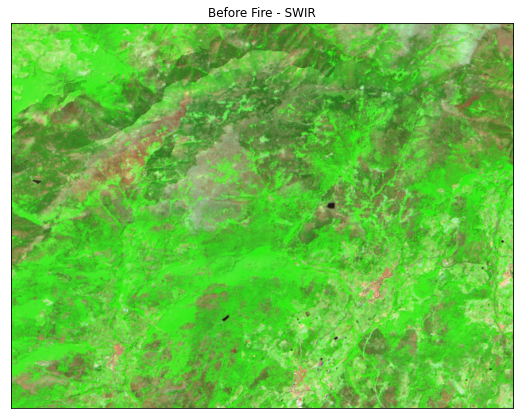

In [440]:
plot_image(image_swir_pre,factor=1/255, clip_range=(0,1))
plt.title('Before Fire - SWIR')
print()

In [441]:
#POST FIRE

evalscript_swir_post = """
    //VERSION=3
    let minVal = 0.0;
    let maxVal = 0.4;

    let viz = new HighlightCompressVisualizer(minVal, maxVal);

    function setup() {
      return {
        input: ["B12", "B8A", "B04", "dataMask"],
        output: { bands: 4 }
      };
    }

    function evaluatePixel(samples) {
        let val = [samples.B12, samples.B8A, samples.B04,samples.dataMask];
        return viz.processList(val);
    }
"""

request_swir_post = SentinelHubRequest(
    data_folder='Sentinel2_savedimages',
    evalscript=evalscript_swir_post,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2020-09-03','2020-09-05'),
            mosaicking_order = 'mostRecent'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=cabezuela_bbox,
    size=cabezuela_size,
    config=config
)

In [442]:
%%time
cabezuela_swir_post = request_swir_post.get_data(save_data=True)
image_swir_post = cabezuela_swir_post[0]

CPU times: user 16.8 ms, sys: 2.96 ms, total: 19.8 ms
Wall time: 39.2 ms


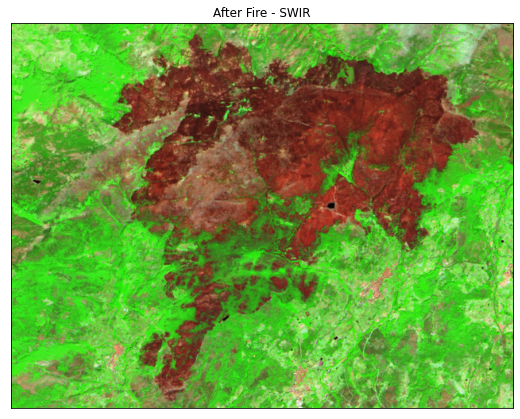

In [443]:
plot_image(image_swir_post,factor=1/255, clip_range=(0,1))
plt.title('After Fire - SWIR')
print()

-------------------

<table><tr>
<td> 
  <p align="center" style="padding: 2 px">
    <img alt="Pre fire" src="SWIR_pre.png" width="500">
    <br>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Post fire" src="SWIR_post.png" width="515">
    <br>
  </p> 
</td>
</tr></table>

The picture of the right part show perfectly the burnt area.

----------------------------------

## GENERAL NOTES. IMPROVEMENTS TO DEVELOP

Please read the next conclusions I have made for my test.
1. The plot_image function has something wrong that I could not be able to figure out that plots all the images in RGB colour (even there are downloaded correctly, in B/W)


2. I would continue the analysis doing:
    - With Rasterio library, divide in variables the bands of the Sentinel 2 image
    - Function dNBR to calculate the real dNBR between the fires
    - Export to Shape the burnt part of the fire
        - With the DEM, clip the raster to get the raster burnt 
        - Reclassify the clip raster burnt
          - Create a Burn Severity Map with 4 categories: Not burned, Low Severity,Medium                  Severity and High Severity
        - Calculate burnt area as categories of Severity
     - With the Forest Spanish Map, it is possible to calculate the percentage of damage in          each forest type.
   
